# Installation Instructions

Clone the repos, install dependencies and install packages terrapin, quest and gsshapy.

Note: terrapin isn't used in this example but it will be in future examples...

```bash
git clone git@public.git.erdc.dren.mil:computational-analysis-and-mechanics/quest.git
git clone git@public.git.erdc.dren.mil:computational-analysis-and-mechanics/terrapin.git
git clone git@github.com:CI-WATER/gsshapy.git

conda env create -n earthsim -f ./terrapin/py3_conda_environment.yml
conda env update -n earthsim -f ./quest/py3_conda_environment.yml
conda env update -n earthsim -f ./gsshapy/conda_env.yml
source activate earthsim

cd terrapin
python setup.py develop
cd ../quest
python setup.py develop
cd ../gsshapy
python setup.py develop
```


In [1]:
%matplotlib inline
from datetime import datetime, timedelta
import os

import geopandas as gpd
from gsshapy.modeling import GSSHAModel
import quest
from matplotlib import colors, cm, pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from gazar import grid
import numpy as np

import xarray as xr
import cartopy.crs as ccrs
from rasterio.warp import transform

In [2]:
#!/env/python
# coding=utf8
# https://gist.github.com/jeteon/89c41e4081d87b798d8006b16a52c695
"""
Converting Degrees, Minutes, Seconds formatted coordinate strings to decimal. 
Formula:
DEC = (DEG + (MIN * 1/60) + (SEC * 1/60 * 1/60))
Assumes S/W are negative. 
"""

import re

def dms2dec(dms_str):
    """Return decimal representation of DMS
    
    >>> dms2dec(utf8(48°53'10.18"N))
    48.8866111111F
    
    >>> dms2dec(utf8(2°20'35.09"E))
    2.34330555556F
    
    >>> dms2dec(utf8(48°53'10.18"S))
    -48.8866111111F
    
    >>> dms2dec(utf8(2°20'35.09"W))
    -2.34330555556F
    
    """
    
    dms_str = re.sub(r'\s', '', dms_str)
    
    sign = -1 if re.search('[swSW]', dms_str) else 1
    
    numbers = list(filter(len, re.split('\D+', dms_str, maxsplit=4)))

    degree = numbers[0]
    minute = numbers[1] if len(numbers) >= 2 else '0'
    second = numbers[2] if len(numbers) >= 3 else '0'
    frac_seconds = numbers[3] if len(numbers) >= 4 else '0'
    
    second += "." + frac_seconds
    return sign * (int(degree) + float(minute) / 60 + float(second) / 3600)

In [3]:
# Convert bounding area from Andrew into bbox
location = 'demo'
y1, x1, y2, x2, y3, x3, y4, x4 = [
        dms2dec("""26°11'31.30"N"""),
        dms2dec("""98°20'53.32"W"""),
        dms2dec("""26° 8'39.53"N"""),
        dms2dec("""97°59'41.00"W"""), 
        dms2dec("""26° 2'21.48"N"""),
        dms2dec("""97°59'39.05"W"""), 
        dms2dec("""26° 4'29.37"N"""),
        dms2dec("""98°21'3.13"W"""),
       ]

ycoords = [y1, y2, y3, y4]
xcoords = [x1, x2, x3, x4]
bbox = [min(xcoords), min(ycoords), max(xcoords), max(ycoords)]
print(bbox)

[-98.35086944444444, 26.0393, -97.99418055555556, 26.192027777777778]


Function to automate the downloading process:

In [4]:
def download_data(service_uri, bbox, collection):
    """
    Downloads raster data from source uri and adds to a quest collection.
    
    If multiple raster tiles are retrieved for the given bounds it calls a quest 
    filter to merge the tiles into a single raster.
    
    Returns quest uid for merged raster
    """
    
    features = quest.api.get_features(service_uri, filters={'bbox': bbox})
    print('Selected raster tiles:', features)
    features = quest.api.add_features(collection, features)
    datasets = quest.api.stage_for_download(features)
    print('start download -->')
    quest.api.download_datasets(datasets)
    print('start merge & clip -->')
    result = quest.api.apply_filter('raster-merge', datasets=datasets, options={'bbox': bbox})
    merged_dataset = result['datasets'][0]
    print('merged raster:', merged_dataset)
    
    return merged_dataset

Parameters to change for the run:

In [5]:
xr.__version__

'0.9.6'

In [6]:
elevation_service = 'svc://usgs-ned:13-arc-second'
land_use_service = 'svc://usgs-nlcd:2011'
land_use_grid_id = 'nlcd'
base_dir = os.getcwd() # path needs to be absolute for gsshapy
gssha_model_name = location + '_with_delineation'
gssha_model_directory = os.path.join(base_dir, gssha_model_name)
boundary_shapefile = os.path.join(base_dir, gssha_model_name, 'watershed_boundary.shp')

The collection is where we will origanize the downloaded data.

In [7]:
## Delete all collections
# for collection in quest.api.get_collections():
#   quest.api.delete(collection)

In [8]:
try:
    quest.api.new_collection(gssha_model_name)
except ValueError as e:
    print(e)

Collection demo_with_delineation already exists


Download the data. This may take some time.

In [9]:
elevation = download_data(elevation_service, bbox, gssha_model_name)

/Users/rditldp9/miniconda3/envs/earthsim/lib/python3.5/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')


Selected raster tiles: ['svc://usgs-ned:13-arc-second/581d21dde4b08da350d53c3c', 'svc://usgs-ned:13-arc-second/581d21dde4b08da350d53c40']
start download -->
... ... .img format raster saved at /Users/rditldp9/Library/Application Support/quest/projects/default/demo_with_delineation/d795679d13fc417ab0f014301860ca1e.img
... ... .img format raster saved at /Users/rditldp9/Library/Application Support/quest/projects/default/demo_with_delineation/d7afd6ca3bbb467aa48840618f9940e1.img
start merge & clip -->
merged raster: d52e2a69fa34401e800035475fd51b27


In [33]:
def plot_raster(dataset_id, title, bbox, cmap, norm=None):
    filename = quest.api.get_metadata(dataset_id)[dataset_id]['file_path']
    ds = xr.open_rasterio(filename)

    # Compute the lon/lat coordinates with rasterio.warp.transform
    ny, nx = len(ds['y']), len(ds['x'])
    x, y = np.meshgrid(ds['x'], ds['y'])

    # Rasterio works with 1D arrays
    lon, lat = transform(ds.crs, {'init': 'EPSG:4326'},
                         x.flatten(), y.flatten())
    lon = np.asarray(lon).reshape((ny, nx))
    lat = np.asarray(lat).reshape((ny, nx))
    ds.coords['lon'] = (('y', 'x'), lon)
    ds.coords['lat'] = (('y', 'x'), lat)

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    xmin, ymin, xmax, ymax = bbox
    display_bbox = [xmin, xmax, ymin, ymax]
    ax.set_extent(display_bbox)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False

    ds.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
               cmap=cmap, add_colorbar=False, norm=norm)
    plt.title(title)

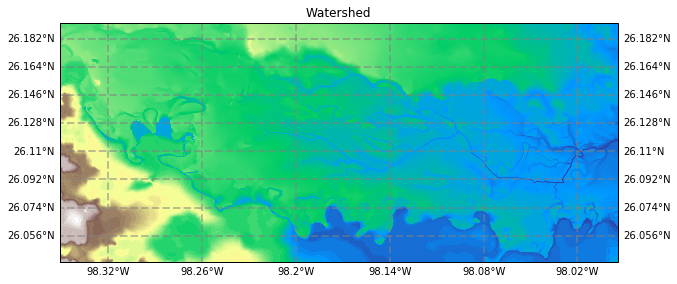

In [34]:
# viz downloaded and merged elevation raster
plot_raster(elevation, 'Watershed', bbox, cm.terrain)

In [13]:
# run pit filling algorithm
algorithm = 'go-fill'  # one of ['flats', 'go-fill', 'go-breach']
result = quest.api.apply_filter('raster-fill', datasets=elevation, options={'algorithm': algorithm})
pit_filled = result['datasets'][0]

# run flow accumulation
algorithm = 'go-d8'  # one of ['d8', 'go-d8', 'go-fd8']
result = quest.api.apply_filter('raster-flow-accumulation', datasets=pit_filled, options={'algorithm': algorithm})
flow_accumulation = result['datasets'][0]

Setting up go-spatial tool: FillDepressions
Running process...
Done!
Setting up go-spatial tool: D8FlowAccumulation
Running process...
Done!


In [ ]:
plot_raster(flow_accumulation, 'Flow Accumulation', bbox, cm.plasma_r, norm=colors.LogNorm())

In [ ]:
plot_raster(flow_accumulation, 'Flow Accumulation', [-98.02, 26.092, -98.08, 26.128], cm.plasma_r, norm=colors.LogNorm())

In [44]:
def watershed_delineation(pit_filled, outlet):
    # generate delineation
    result = quest.api.apply_filter('raster-watershed-delineation', datasets=pit_filled, 
                       options={'outlet_points': outlet, 'snap_outlets': 'jenson', 'stream_threshold_pct': 0.02})
    return result['features']['watershed'], result['features']['outlet']

In [45]:
# use the merged raster to create a shapefile
outlet = [(-98.26, 26.08)]
watershed, outlet = watershed_delineation(pit_filled, outlet)
#flow_accumulation = watershed_delineation(elevation, outlet)
#print(watershed, outlet, flow_accumulation)

outlet points snapped, new feature created: [(-98.26003045171339, 26.07995948723132)] f71abe3d24a14f278e9eefa48959856f


IndexError: list index out of range

In [ ]:
flow_accumulation

4.641413954585759e-08 -98.25808588611976 26.08264542146756


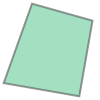

In [43]:
# viz watershed
watershed_geometry = quest.api.get_metadata(watershed)[watershed]['geometry']
outlet_lon, outlet_lat = np.array(quest.api.get_metadata(outlet)[outlet]['geometry'].coords.xy).squeeze().tolist()
print(watershed_geometry.area, outlet_lon, outlet_lat)
watershed_geometry

In [ ]:
## read in & plot flow accumulation
flow_accumulation_file = quest.api.get_metadata(flow_accumulation)[flow_accumulation]['file_path']
flow_accumulation_dataset = grid.GDALGrid(flow_accumulation_file)
flow_accumulation_data = flow_accumulation_dataset.np_array()

max_accumulation = flow_accumulation_data.max()
stream_threshold = max_accumulation * 0.01
rivers = np.ma.masked_where(flow_accumulation_data < stream_threshold, flow_accumulation_data)
plt.imshow(flow_accumulation_data, cmap=cm.terrain, norm=colors.LogNorm())

In [ ]:
# read in elevation data
dem_file = quest.api.get_metadata(elevation)[elevation]['file_path']
dem = grid.GDALGrid(dem_file)
lat, lon = dem.latlon

In [ ]:
# plot outlet pixel and river network
window = 200
stream_threshold = flow_accumulation_data.max() * 0.01
rivers = np.ma.masked_where(flow_accumulation_data < stream_threshold, flow_accumulation_data)
fig, ax = plt.subplots()
ax.imshow(np.flip(dem.np_array(), 0))
plt.imshow(np.flip(rivers, 0), cmap=cm.gray_r, norm=colors.LogNorm(), origin="lower")
outlet_col, outlet_row = flow_accumulation_dataset.lonlat2pixel(outlet_lon, outlet_lat)
ax.scatter(x=outlet_col, y=rivers.shape[0] - outlet_row, s=50, color='red')
ax.set_xlim((outlet_col-window,outlet_col+window))
ax.set_ylim((outlet_row-window,outlet_row+window))

In [ ]:
# plot the generated watershed with outlet point
watershed_geometry = quest.api.get_metadata(watershed)[watershed]['geometry']
outlet_lon, outlet_lat = quest.api.get_metadata(outlet)[outlet]['geometry'].coords.xy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import colors, cm, pyplot as plt

xmin, ymin, xmax, ymax = bbox
display_bbox = [xmin, xmax, ymin, ymax]
graticule_spacing = 0.01

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(display_bbox)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False

plt.contourf(lon, lat, dem.np_array(), 100, zorder=2, cmap=cm.terrain, transform=ccrs.PlateCarree())
ax.imshow(rivers, cmap=cm.ocean, origin='lower', zorder=3)
watershed_shp = cfeature.ShapelyFeature([watershed_geometry], ccrs.PlateCarree())
ax.add_feature(watershed_shp, zorder=4, alpha=0.6)
ax.scatter(x=outlet_lon, y=outlet_lat, color='red', zorder=5, transform=ccrs.PlateCarree())
plt.title("Watershed")
plt.show()

In [ ]:
land_use = download_data(land_use_service, bbox, gssha_model_name)

Use the data to generate a GSSHA model. This may take a minute.

In [ ]:
# Save Watershed as a Shapefile for GSSHA
ws = quest.api.get_metadata(watershed, as_dataframe=True)
del ws['created_at'] # gpd error on save
ws.to_file(boundary_shapefile)

In [ ]:
elevation_file_path = quest.api.get_metadata(elevation)[elevation]['file_path']
land_use_file_path = quest.api.get_metadata(land_use)[land_use]['file_path']

In [ ]:
# make the directory for the output
try:
    os.mkdir(gssha_model_directory)
except OSError:
    pass

# generate GSSHA model files
model = GSSHAModel(project_name=gssha_model_name,
                   project_directory=gssha_model_directory,
                   mask_shapefile=boundary_shapefile,
                   elevation_grid_path=elevation_file_path,
                   land_use_grid=land_use_file_path,
                   land_use_grid_id=land_use_grid_id,
                   out_hydrograph_write_frequency=1,
                   )

# add card for max depth
model.project_manager.setCard('FLOOD_GRID',
                              '{0}.fgd'.format(gssha_model_name),
                              add_quotes=True)
# TODO: Add depth grids to simulation
# MAP_FREQ, DEPTH

# add event for simulation
model.set_event(simulation_start=datetime.utcnow(),
                simulation_duration=timedelta(seconds=2*60),
                rain_intensity=24,
                rain_duration=timedelta(seconds=1*60),
                )
model.write()